> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - 'No show' appointments in Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included: gender, age, the date appointment was made, the appointment date, neigbourhood, scholarship, number of diagnosis(hipertension, diabetis, alcoholism and handicap), SMS-notification received and info if the patient actually showed up or not.

> **Additional info**
-  ‘Neighborhood’ indicates the location of the hospital.
-  ‘Scholarship’ indicate swhether or not the patient isenrolled in Brasilian welfare program Bolsa Família.
-  'No Show' encoding: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.

The original dataset comes from Kaggle.

#### The questions:

1. What is the overall show up rate?
2. What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


<a id='wrangling'></a>
## Data Wrangling

### General Properties

#### Loading the data from url and checking that it is loaded correctly

In [42]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv')
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


#### Getting the overview - dataframe size, features, data types and cleanliness

In [43]:
df.shape

(110527, 14)

In [44]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [46]:
df.duplicated().sum()


0

The data set consists of 110 527 rows and 14 columns. Data set doesn't contain duplicates.

**Data set observations**

-  ScheduledDay and AppointmentDay should be converted to datetime 
-  It makes sense to introduce WaitingTime column to analyze how waiting time affect No-show rate
-  Change PatientID from float to int
-  No-show column should be converted from Yes/No to 0/1
-  Age has min value -1 and max value 115. Max value is quite big, but still realistic, while min value doesn't make sense
-  Handicap has max value of 4. It worth looking into the reasons of it and if it should be converted to Yes/No
-  AppointmentID is not relevant for the analysis and can be dropped




### Data Cleaning 

#### Fixing -1 in Age column

In [47]:
meanAge = df['Age'].mean()
df[df['Age'] < 0] = meanAge.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


#### ScheduledDay and AppointmentDay should be converted to datetime

In [48]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


In [49]:
df['AppointmentDay'] = df['AppointmentDay'].apply(lambda x: x.date())
df['ScheduledDay'] = df['ScheduledDay'].apply(lambda x: x.date())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [50]:
df['WaitingTime'] = (df['AppointmentDay'].sub(df['ScheduledDay'], axis=0)).abs()
df['WaitingTime'] = df['WaitingTime'].astype('timedelta64[D]')
df['WaitingTime'] = df['WaitingTime'].astype(int)
df.head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,5.589978e+14,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4.262962e+12,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,8.679512e+11,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8.841186e+12,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
WaitingTime       110527 non-null int64
dtypes: float64(1), int64(9), object(5)
memory usage: 12.6+ MB


#### Change PatientId from float to int

In [52]:
df['PatientId'] = df['PatientId'].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 15 columns):
PatientId         110527 non-null int64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
WaitingTime       110527 non-null int64
dtypes: int64(10), object(5)
memory usage: 12.6+ MB


#### No-show column should be converted from Yes/No

In [53]:
df['No-show'] = np.where((df['No-show']=='Yes'), 1, 0)
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


#### Handicap has max value of 4. It worth looking into the reasons of it and if it should be converted to 0/1

In [54]:
np.unique(df['Handcap'], return_counts=True)

(array([ 0,  1,  2,  3,  4, 37]),
 array([108285,   2042,    183,     13,      3,      1]))

It tunrs out, that Handicap column contains values from 0 to 4, with outlier 37.08887421. Additional research reveals that values 1 to 4 represent the severity of the disability. For the purpose of the analysis we just need the fact of disbalitily, without going into much detail, therefore this column can be converted to reprsent the presence of the disability - 0/1

In [55]:
df['Handcap'] = np.where((df['Handcap']>0), 1, 0)
np.unique(df['Handcap'], return_counts=True)

(array([0, 1]), array([108285,   2242]))

<a id='eda'></a>
## Exploratory Data Analysis

#### Create 2 dataframes to hold no-show and show records

In [56]:
no_shows = df[df['No-show'] == 1]
no_shows.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime
6,733688164476661,5630279,F,2016-04-27,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,1,2
7,3449833394123,5630575,F,2016-04-27,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,1,2
11,7542951368435,5620163,M,2016-04-26,2016-04-29,29,NOVA PALESTINA,0,0,0,0,0,1,1,3
17,14794966191172,5633460,F,2016-04-28,2016-04-29,40,CONQUISTA,1,0,0,0,0,0,1,1
20,622257462899397,5626083,F,2016-04-27,2016-04-29,30,NOVA PALESTINA,0,0,0,0,0,0,1,2


In [57]:
show_ups = df[df['No-show'] == 0]
show_ups.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitingTime
0,29872499824296,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,0,0
1,558997776694438,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,0,0
2,4262962299951,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,0,0
3,867951213174,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,0,0
4,8841186448183,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,0,0


### Questions

#### 1. General No-Shows vs Show-ups rate

In [58]:
show_df = df.groupby('No-show')['No-show'].agg(['count'])
show_df.reset_index(inplace=True)
show_df.columns = ['status', 'total']
show_df.iloc[0,0] = "No Show"
show_df.iloc[1,0] = "Show"
no_show = show_df.iloc[0,1] / (show_df.iloc[0,1] + show_df.iloc[1,1])
shows_up = show_df.iloc[1,1] / (show_df.iloc[0,1] + show_df.iloc[1,1])
show_df['percentage'] = [no_show, shows_up]
show_df.head()

,status,total,percentage
0,No Show,88208,0.798067
1,Show,22319,0.201933


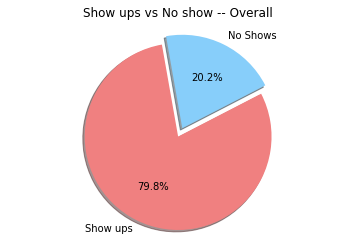

In [59]:
labels = ['Show ups','No Shows']
sizes = [no_show, shows_up]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=100)
plt.title('Show ups vs No show -- Overall')
plt.axis('equal');


Overall Show up rate is 79.8% vs 20.2% of No shows.

#### 2. Age distribution Show ups vs No Shows

In [60]:
no_shows['Age'].mean()

34.317666562121957

In [61]:
show_ups['Age'].mean()

37.790495193179758

Mean age of No-show dataframe is 34.31 vs mean age of Show-ups dataframe - 37.79. It is not significant difference.

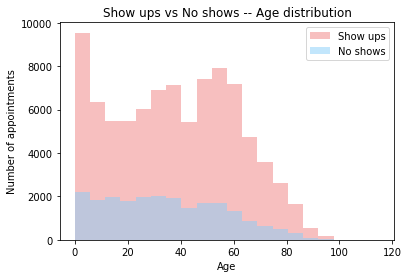

In [62]:
plt.hist(show_ups['Age'], stacked=True, bins=20, alpha=0.5, color='lightcoral', label = 'Show ups')
plt.hist(no_shows['Age'], stacked=True, bins=20, alpha=0.5, color='lightskyblue', label = 'No shows')
plt.title('Show ups vs No shows -- Age distribution')
plt.xlabel('Age')
plt.ylabel('Number of appointments');
plt.legend(loc='upper right');

The graph shows that there is almost no correlation between age and no-show rate. The distributions are alike, with a slight 'anomaly' for infants showing higher show up rate.

#### 3. Show ups/No shows by Gender

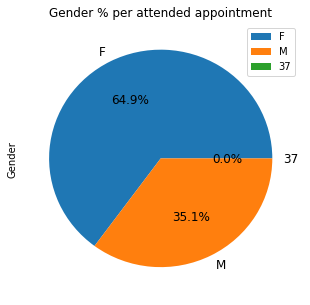

In [63]:
allShowed = show_ups['Gender'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Gender' + ' % per attended appointment', fontsize = 12);
plt.legend();

It turns out that the data is still not clean - there is value 37 in the legend. Let's check it out.

In [64]:
show_ups['Gender'].value_counts()

F     57245
M     30962
37        1
Name: Gender, dtype: int64

In [65]:
no_shows['Gender'].value_counts()

F    14594
M     7725
Name: Gender, dtype: int64

In [66]:
show_ups = show_ups[show_ups.Gender != 37]
show_ups['Gender'].value_counts()

F    57245
M    30962
Name: Gender, dtype: int64

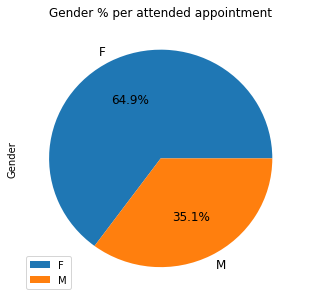

In [67]:
allShowed = show_ups['Gender'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Gender' + ' % per attended appointment', fontsize = 12);
plt.legend();

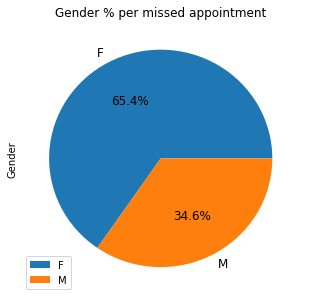

In [68]:
allNotShowed = no_shows['Gender'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Gender' + ' % per missed appointment', fontsize = 12);
plt.legend();

According to the 1st pie chart - Attendace rates - there 64.9% females and 35.1% of males among the people who showed up. On 2nd chart the breakdown of the No-shows is represented - 65,4% females and 34.6% males. Both chart show almost the same values, that leads to the conclusion that Gender has no impact on attendacne rate.

#### 4. Show ups/No shows by Neigbourhood

In [69]:
show_ups['Neighbourhood'].value_counts().head(10)




JARDIM CAMBURI     6252
MARIA ORTIZ        4586
RESISTÊNCIA        3525
JARDIM DA PENHA    3246
SANTA MARTHA       2635
CENTRO             2631
ITARARÉ            2591
TABUAZEIRO         2559
SANTO ANTÔNIO      2262
BONFIM             2223
Name: Neighbourhood, dtype: int64

In [70]:
no_shows['Neighbourhood'].value_counts().head(10)

JARDIM CAMBURI       1465
MARIA ORTIZ          1219
ITARARÉ               923
RESISTÊNCIA           906
CENTRO                703
JESUS DE NAZARETH     696
JARDIM DA PENHA       631
CARATOÍRA             591
TABUAZEIRO            573
BONFIM                550
Name: Neighbourhood, dtype: int64

I didn't draw any charts here. First look at the feature indicated that drawing the chart without filtering the values won't make no sence, becuase of the amount of values and also because of actual insignificance of many of them. Therefore I decided to list top 10 first. It turned out that Top 10 'Attended' vs Top 10 'No show' list look similar. Based on this list one can already tell that there is no significant influence.

#### 5. Show ups/No shows among Scholarship holders

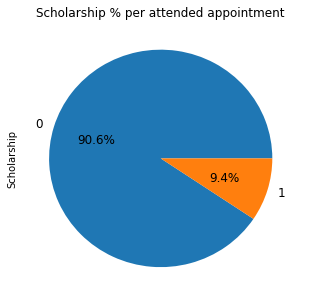

In [71]:
allShowed = show_ups['Scholarship'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Scholarship' + ' % per attended appointment', fontsize = 12);

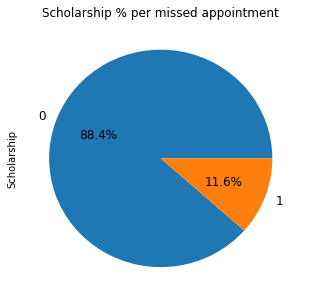

In [72]:
allNotShowed = no_shows['Scholarship'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Scholarship' + ' % per missed appointment', fontsize = 12);

According to the 1st pie chart - Attendace rates - there 90.6% recievers of the scholarship and 9.4% of people who are not receiving it among the people who showed up. On 2nd chart the breakdown of the No-shows is represented - 88.44% scholars and 11.6% non-scholars. Both chart show almost the same values, that leads to the conclusion that the Schloraship has no impact on attendacne rate.

#### 6. Show ups/No shows based on Healt condition -- Alcoholism

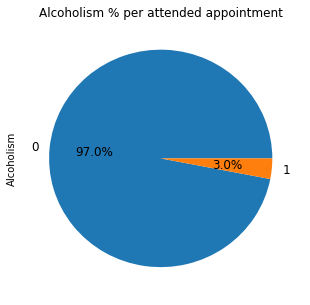

In [73]:
allShowed = show_ups['Alcoholism'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Alcoholism' + ' % per attended appointment', fontsize = 12);

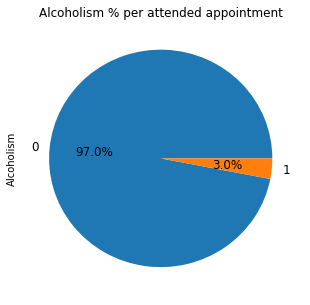

In [74]:
allNotShowed = no_shows['Alcoholism'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Alcoholism' + ' % per attended appointment', fontsize = 12);

The chart 1 shows the proportion of people who attended their appointments based on heath condition 'Alcoholism'. Chart 2 breaks down the No show rate based on the same condition. The values shown by both chars are exactly the same, that supports the conclusion that there is no correlation between Alcoholism and No-show rate.

#### 6. Show ups/No shows based on Healt condition -- Diabeties

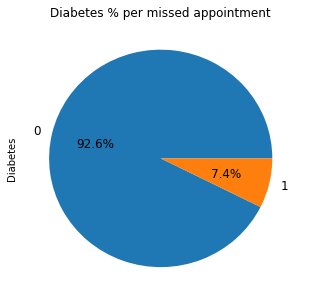

In [75]:
allShowed = show_ups['Diabetes'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Diabetes' + ' % per missed appointment', fontsize = 12);

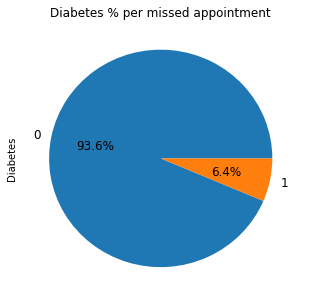

In [76]:
allNotShowed = no_shows['Diabetes'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Diabetes' + ' % per missed appointment', fontsize = 12);

The chart 1 shows the proportion of people who attended their appointments based on heath condition 'Diabeties'. Chart 2 breaks down the No show rate based on the same condition. The values shown by both chars are very close - 7.4% vs 6.4%, that supports the conclusion that there is no correlation between Diabeties and No-show rate.

#### 7. Show ups/No shows based on Healt condition -- Hipertension

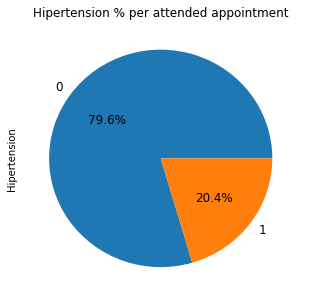

In [77]:
allShowed = show_ups['Hipertension'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Hipertension' + ' % per attended appointment', fontsize = 12);

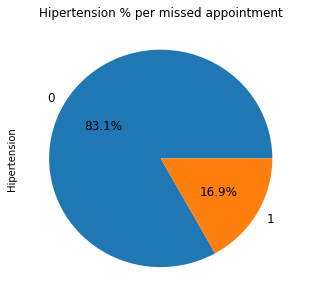

In [78]:
allNotShowed = no_shows['Hipertension'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Hipertension' + ' % per missed appointment', fontsize = 12);

The chart 1 shows the proportion of people who attended their appointments based on heath condition 'Hipertesion'. Chart 2 breaks down the No show rate based on the same condition. The values shown by both chars are very close - 20.4% vs 16.9%, but worth taking a look into.

#### 7. Show ups/No shows based on Healt condition -- Handicap

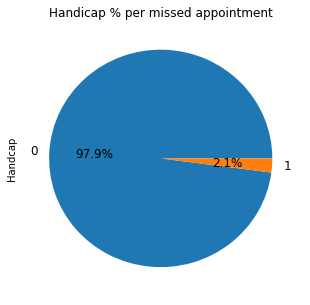

In [79]:
allShowed = show_ups['Handcap'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Handicap' + ' % per missed appointment', fontsize = 12);

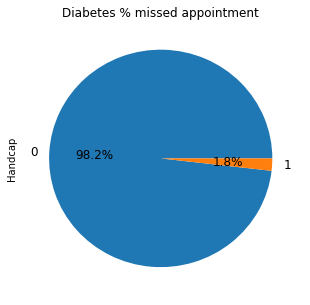

In [80]:
allNotShowed = no_shows['Handcap'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('Diabetes' + ' % missed appointment', fontsize = 12);

The chart 1 shows the proportion of people who attended their appointments based on heath condition 'Handicap'. Chart 2 breaks down the No show rate based on the same condition. The values shown by both chars are very close - 2.1% vs 1.8%, that supports the conclusion that there is no correlation between Handicap and No-show rate.

#### 7. Show ups/No shows relation to SMS notification

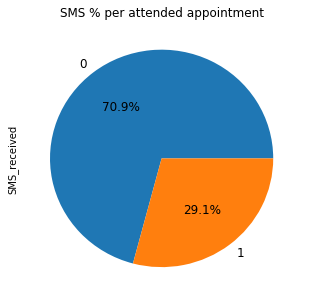

In [81]:
allShowed = show_ups['SMS_received'].value_counts()
pieChart = allShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('SMS' + ' % per attended appointment', fontsize = 12);

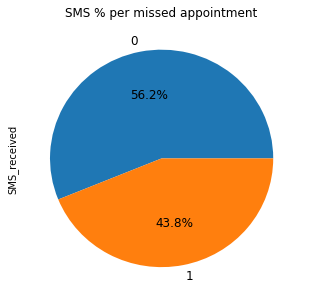

In [82]:
allNotShowed = no_shows['SMS_received'].value_counts()
pieChart = allNotShowed.plot.pie(figsize=(5,5), autopct='%1.1f%%', fontsize = 12);
pieChart.set_title('SMS' + ' % per missed appointment', fontsize = 12);

According to the 1st pie chart - Attendace rates - there 70.9% who didn't recieve SMS and 29.1% who did receive SMS-reminder among the people who showed up. On 2nd chart the breakdown of the No-shows is represented - 56,2% not received SMS and 43.8% did. This is very surprising statistics, I have expected quiet opposite! Turns out that SMS is not really working as it meant to.

#### 7. Show ups/No shows relation to Waiting time

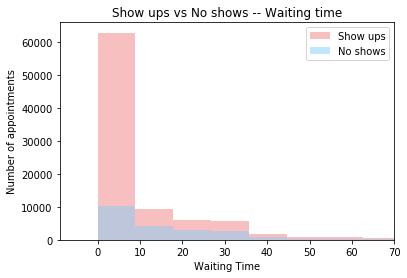

In [83]:
plt.hist(show_ups['WaitingTime'], bins = 20, alpha=0.5, color='lightcoral', label = 'Show ups')
plt.hist(no_shows['WaitingTime'], bins = 20, alpha=0.5, color='lightskyblue', label = 'No shows')
plt.title('Show ups vs No shows -- Waiting time')
plt.xlabel('Waiting Time')
plt.ylabel('Number of appointments');
plt.gca().set_xlim(right = 70)
plt.legend(loc='upper right');

The graph shows the correlation between Waiting time and Show up rate. It appears to be the most important factore so far - after 1 weeek waiting time, attendance rate drops significantly, from approx 10% no-shows to 50% no shows and stays consistent over the period > 10 days around 50%!

#### <a id='conclusions'></a>
## Conclusions

**Limitations**
- The data set explored is for ~6 month period. It doesn't provide insight into how seasonality and holidays impact on the show rates.

- Additional data such as traffic or  weather could allow us to better understand the reasons of no-shows.

- The above analysis are two dimensional, multivariate analysis could reveal more complex trends.

Nearly 20% of all appointments investigated were no-shows. I analysed 5 factrors that could have infuence on that number and here are my findings: 

1. **Age** --
There is almost no correlation between age and no-show rate. There is a slight 'anomaly' for infants showing higher show up rate, that can be explained by the fact that infant appointments are obligatory. Failing to attend them could result in legal action against parents. Apart from this age droup, the distribution looks normal.

2. **Gender** --
No correlation. Both males and females have the same attendance ratio.

3. **Health conditions(Alcoholism, Diabeties, Hipeptension, Handicap)** --
Almost no correlation, onlu Hipertension condiotion seem to influence show-up rate slightly (16.9 no show vs 20.4 show up rate)

4. **SMS notification** --
Showed a suprising result - only 29.1% of the people who showed up receive the SMS notification, comparing with 43.8% amond non-shows. It worth digging into, maybe sms notification is not effective tool in this case.

5. **Waiting time** --
Turns out, this is the most important factor. The study shows that after 1 weeek waiting time, attendance rate drops significantly, from approx 10% no-shows to 50% no shows.




In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])